# Transfer Learning with TensorFlow: Fine Tuning (PART 2 - continuation)

In [1]:
!wget "https://raw.githubusercontent.com/molleremil/helper_functions/main/tf_helper_func.py"

--2023-12-07 23:15:17--  https://raw.githubusercontent.com/molleremil/helper_functions/main/tf_helper_func.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10304 (10K) [text/plain]
Saving to: ‘tf_helper_func.py’

tf_helper_func.py   100%[===================>]  10.06K  --.-KB/s    in 0s      

2023-12-07 23:15:17 (91.7 MB/s) - ‘tf_helper_func.py’ saved [10304/10304]



In [2]:
from tf_helper_func import unzip_data, create_tensorboard_callback, compare_histories, plot_loss_curves, pred_and_plot_mc

# 1. Get data

In [3]:
!wget "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip"

--2023-12-07 23:15:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.196.207, 74.125.134.207, 74.125.139.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.196.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   159MB/s    in 1.0s    

2023-12-07 23:15:23 (159 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
unzip_data("10_food_classes_10_percent.zip")

In [34]:
# Create train and test dirs
train_dir_10_pct = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [6]:
import os

# Inspect the data
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent/"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_10_percent/
There are 10 directories and 0 images in 10_food_classes_10_percent/test
There are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi
There are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice
There are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen
There are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings
There are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry
There are 0 directories and 250 images in 10_food_classes_10_percent/test/steak
There are 10 director

In [35]:
import tensorflow as tf

IMG_SIZE = (224, 224)

# Setup data loaders
train_data_10_pct = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_pct,
                                                                        label_mode="categorical",
                                                                        image_size=IMG_SIZE
                                                                        )
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir_10_pct,
                                                                       label_mode="categorical",
                                                                       image_size=IMG_SIZE
                                                                       )

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Create model with data augmentation

In [12]:
from tensorflow import keras
input_shape = (224, 224, 3)
initial_epochs = 5

# Setup data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomFlip("horizontal")
], name="data_augmentation_layer")

# Build model
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False
inputs = tf.keras.layers.Input(shape=input_shape)
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_2D_layer")(x)
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_1 = tf.keras.Model(inputs, outputs)

# Compile model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

checkpoint_path = 'ten_pct_model_checkpoints_weights/checkpoints.ckpt'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only = True,
    save_freq = "epoch",
    save_best_only=True,
    verbose=1)

history_10_pct_data_aug = model_1.fit(train_data_10_pct,
                                  epochs=initial_epochs,
                                  steps_per_epoch=len(train_data_10_pct),
                                  validation_data=test_data_10_pct,
                                  validation_steps=int(0.25 * len(test_data_10_pct)),
                                  callbacks=[model_checkpoint_callback])

Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9468 - accuracy: 0.3653
Epoch 1: val_loss improved from inf to 1.45317, saving model to ten_pct_model_checkpoints_weights/checkpoints.ckpt
24/24 [==============================] - 23s 558ms/step - loss: 1.9468 - accuracy: 0.3653 - val_loss: 1.4532 - val_accuracy: 0.6595
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3329 - accuracy: 0.6787
Epoch 2: val_loss improved from 1.45317 to 1.06530, saving model to ten_pct_model_checkpoints_weights/checkpoints.ckpt
24/24 [==============================] - 13s 491ms/step - loss: 1.3329 - accuracy: 0.6787 - val_loss: 1.0653 - val_accuracy: 0.7352
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0825 - accuracy: 0.7280
Epoch 3: val_loss improved from 1.06530 to 0.83130, saving model to ten_pct_model_checkpoints_weights/checkpoints.ckpt
24/24 [==============================] - 13s 506ms/step - loss: 1.0825 - accuracy: 0.7280 - val_loss: 0.

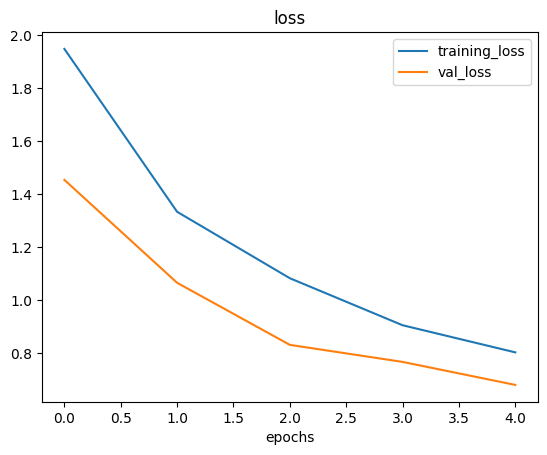

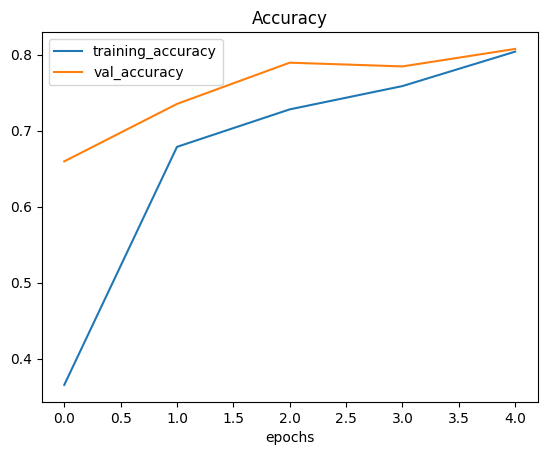

In [13]:
plot_loss_curves(history_10_pct_data_aug)

In [15]:
results_10_pct_data_aug = model_1.evaluate(test_data_10_pct)

79/79 [==============================] - 8s 85ms/step - loss: 0.6554 - accuracy: 0.8300


In [16]:
results_10_pct_data_aug

[0.655446469783783, 0.8299999833106995]

In [17]:
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 3)     0         
 equential)                                                      
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_2D_  (None, 1280)              0         
 layer (GlobalAveragePoolin                                      
 g2D)                                                            
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [20]:
for index, layer in enumerate(model_1.layers):
  print(index, layer.name, layer.trainable)

0 input_10 True
1 data_augmentation_layer True
2 efficientnetv2-b0 False
3 global_average_pooling_2D_layer True
4 output_layer True


In [25]:
for layer in model_1.layers[2].layers:
  if layer.trainable:
    print(layer)

In [26]:
for index, layer in enumerate(base_model.layers):
  print(index, layer.name, layer.trainable)

0 input_9 False
1 rescaling_4 False
2 normalization_4 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [27]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
  layer.trainable = False

In [30]:
for index, layer in enumerate(model_1.layers[2].layers):
  if layer.trainable == True:
    print(index, layer.name, layer.trainable)

260 block6h_se_reduce True
261 block6h_se_expand True
262 block6h_se_excite True
263 block6h_project_conv True
264 block6h_project_bn True
265 block6h_drop True
266 block6h_add True
267 top_conv True
268 top_bn True
269 top_activation True


# Import and unzip 100% of the data

In [31]:
!wget "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip"
unzip_data("10_food_classes_all_data.zip")

--2023-12-07 23:42:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.218.207, 108.177.13.207, 74.125.26.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.218.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   127MB/s    in 3.8s    

2023-12-07 23:42:26 (129 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [32]:
# Setup train dir and data loader
train_dir_all_data = "10_food_classes_all_data/train/"

train_data_all = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                     label_mode="categorical",
                                                                     image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.


In [33]:
train_data_all.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Fine-tune model

In [37]:
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

fine_tune_epochs = initial_epochs + 5

history_fine_full_data = model_1.fit(train_data_all,
                                         epochs=fine_tune_epochs,
                                         validation_data=test_data,
                                         validation_steps=int(0.25*len(test_data)),
                                         initial_epoch=history_10_pct_data_aug.epoch[-1],
                                         callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                experiment_name="fine_tune_all_data")])

Saving TensorBoard log files to: transfer_learning/fine_tune_all_data/20231208-000619
Epoch 5/10
235/235 [==============================] - 96s 354ms/step - loss: 0.7073 - accuracy: 0.7740 - val_loss: 0.4065 - val_accuracy: 0.8750
Epoch 6/10
235/235 [==============================] - 71s 297ms/step - loss: 0.5830 - accuracy: 0.8115 - val_loss: 0.3470 - val_accuracy: 0.8865
Epoch 7/10
235/235 [==============================] - 58s 243ms/step - loss: 0.5245 - accuracy: 0.8311 - val_loss: 0.3255 - val_accuracy: 0.8849
Epoch 8/10
235/235 [==============================] - 51s 216ms/step - loss: 0.4901 - accuracy: 0.8408 - val_loss: 0.3147 - val_accuracy: 0.8997
Epoch 9/10
235/235 [==============================] - 51s 216ms/step - loss: 0.4566 - accuracy: 0.8544 - val_loss: 0.3151 - val_accuracy: 0.8980
Epoch 10/10
235/235 [==============================] - 44s 183ms/step - loss: 0.4474 - accuracy: 0.8564 - val_loss: 0.3051 - val_accuracy: 0.9079


In [38]:
results_full_data_fine = model_1.evaluate(test_data)

79/79 [==============================] - 9s 107ms/step - loss: 0.2754 - accuracy: 0.9108


In [39]:
results_full_data_fine

[0.2753831744194031, 0.9107999801635742]

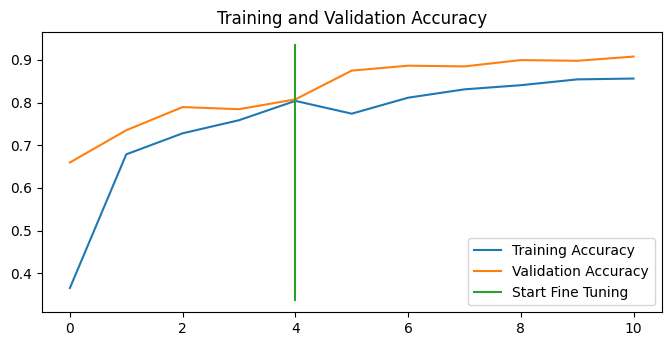

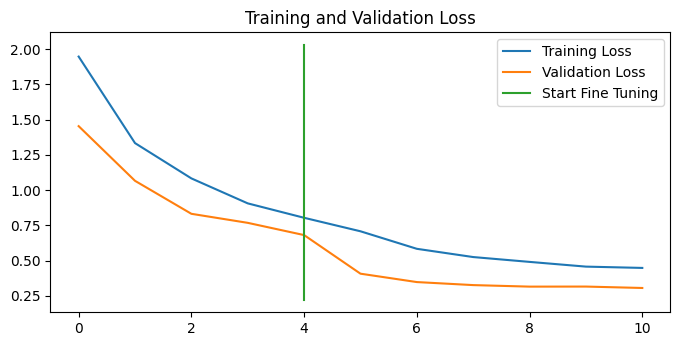

In [40]:
compare_histories(original_history=history_10_pct_data_aug,
                  post_history=history_fine_full_data,
                  initial_epochs=initial_epochs)